# Study - E vs Delta-Z

## Runs 6482 

### These Runs are very stables in lifetime and lifetime x,y maps vs time

In [123]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Dec  4 18:47:55 2018


In [124]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   scipy import optimize
import invisible_cities.core.fit_functions as fitf
from  invisible_cities.core .core_functions import in_range

import krcal.utils.plt_functions          as krplot
import krcal.utils.hst_extend_functions   as hst

import csth.utils.cepeak_plot             as cpkplot

In [126]:
# Plotting style
default_cmap = "jet"
figure_size  = 14, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [190]:
run_numbers = [6482, 6483]
#input_filename = f"$IC_DATA/{run_number}/pmaps/cepks_{run_number}_90_9188_{trigger}.h5"
tag = '6q0min'
input_filenames = [f"$IC_DATA/cepks/cepks_{run_number}_0000_11999_{tag}.h5" for run_number in run_numbers]
input_files     = [os.path.expandvars(ifile) for ifile in input_filenames]

In [191]:
def esum_from_hdf(filename, clear = True):
    print(filename)
    h = pd.HDFStore(filename)
    esum = h['esum']
    print('total events :', len(esum))
    esum.dropna()
    x, y = esum.x.values, esum.y.values
    r = np.sqrt(x*x + y*y)
    esum['r']    = r
    sel_base = (esum.nslices > 0) & (esum.nhits > 0) & (esum.s1e > 0) & (esum.q0 > 0) & (esum.e0 > 0)
    esum = esum[sel_base]
    print('clean events :', len(esum) )
    x, y = esum.x.values, esum.y.values
    r = np.sqrt(x*x + y*y)
    esum['r']    = r
    sel_fid  = (esum.r < 150) & (esum.z > 30) & (esum.z < 520)
    esum = esum[sel_fid]
    print('fidutial events :', len(esum) )
    #esum0 = esum[sel_base]
    #h.close()
    return esum

In [192]:
esums = [esum_from_hdf(ifile) for ifile in input_files]

/Users/hernando/investigacion/NEXT/data/runIV//cepks/cepks_6482_0000_11999_6q0min.h5
total events : 556662
clean events : 556662
fidutial events : 330298
/Users/hernando/investigacion/NEXT/data/runIV//cepks/cepks_6483_0000_11999_6q0min.h5
total events : 522662
clean events : 522662
fidutial events : 309541


In [193]:
esum = esums[0]
print(len(esum))
for i, iesum in enumerate(esums[1:]):
    esum = esum.append(iesum, ignore_index = True)
print(len(esum))

330298
639839


In [194]:
#cpkplot.df(esum)

In [195]:
Ea = hst.Vaxis((0., 700e3), 500)
def canvas_e(esums):
    alpha = 1./len(esums)
    #c = hst.Canvas(1, 1)
    for i, esum in enumerate(esums):
        plt.hist(esum.e, Ea.bins, alpha = alpha) 
        plt.xlabel('E (pes)')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()

No handles with labels found to put in legend.


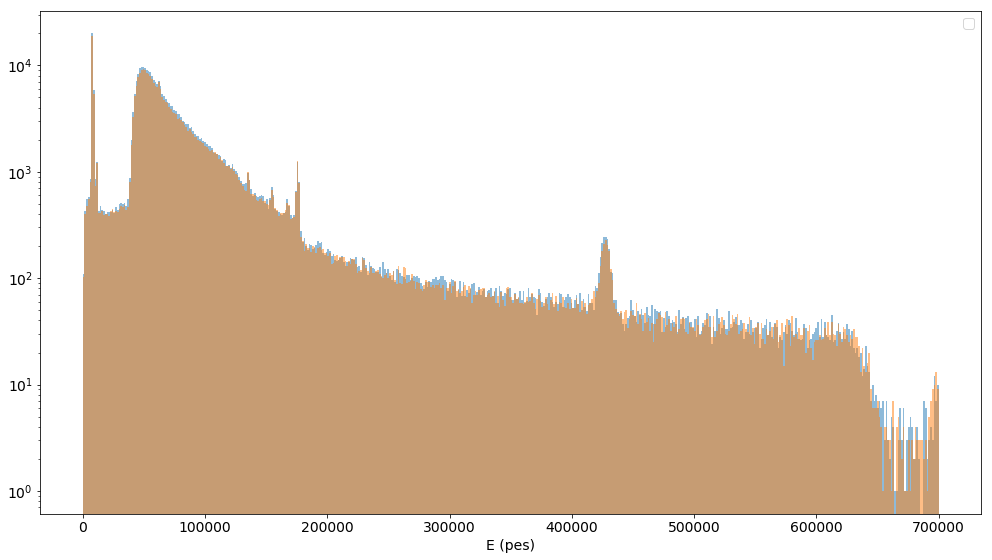

In [196]:
canvas_e(esums)

In [197]:
tags = [str(run) for run in run_numbers]

#Exra = hst.Vaxis((  5e3,  50e3), 100)
#Ecsa = hst.Vaxis(( 50e3, 200e3), 100)
#Edsa = hst.Vaxis((100e3, 800e3), 200)
#Etha = hst.Vaxis((450e3, 800e3), 100)


Exra = hst.Vaxis((  5e3,  10e3), 100)
Ecsa = hst.Vaxis((110e3, 190e3), 100)
Edsa = hst.Vaxis((400e3, 460e3), 100)
Etha = hst.Vaxis((500e3, 750e3), 100)
def canvas_eregions(esums, i0 = 0):
    alpha = 1./len(esums)
    c = hst.Canvas(2, 2)
    for i, esum in enumerate(esums):
        hst.hist(esum.e, Exra.bins, alpha = alpha, stats = None, canvas = c(1), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Ecsa.bins, alpha = alpha, stats = None, canvas = c(2), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Edsa.bins, alpha = alpha, stats = None, canvas = c(3), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Etha.bins, alpha = alpha, stats = None, canvas = c(4), label = tags[i + i0], xylabels=('E (pes)',''))
    plt.legend()
    plt.tight_layout()

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


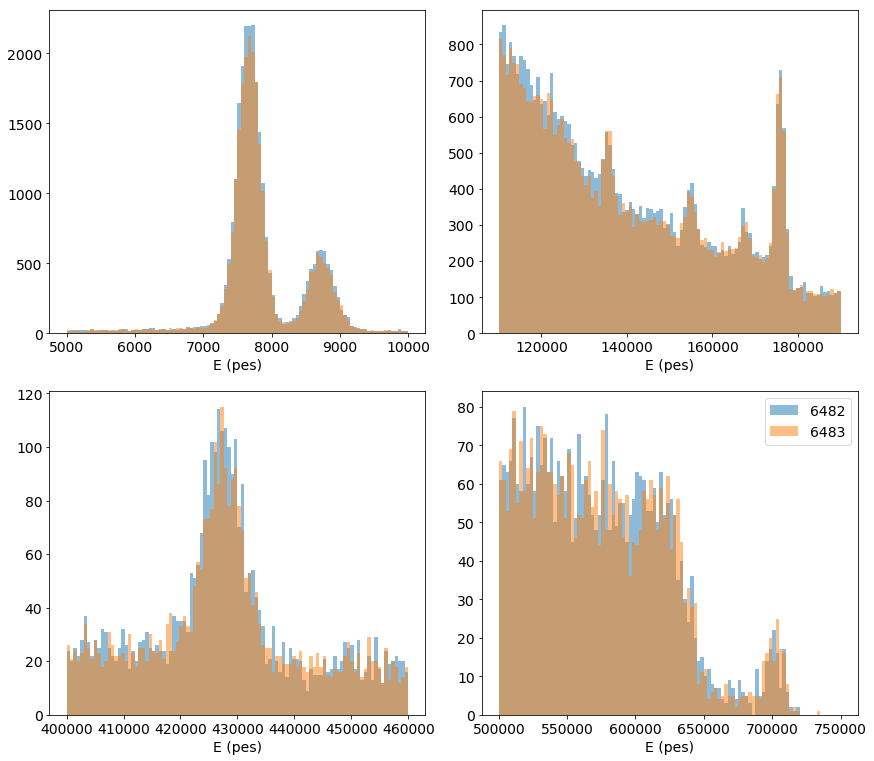

In [198]:
canvas_eregions(esums, 0)
#canvas_eregions(esums[4:],  4)

In [199]:
def canvas_efit(ee, erange, nbins= 100, tag='', alpha = 0.5):
    e0, e1 = erange
    dssel = in_range(ee, e0, e1)
    es    = ee[dssel]
    n     = np.sum(dssel)
    mu    = np.mean(es)
    sigma = np.std(es)
    mslope = 0.
    f      = 0.5
    x0     = np.array([n/2, n/2, mslope, mu, sigma])
    
    res, cov = phfit.pkfit(es, (e0, e1), x0)
    xhat = res.x
    #print('xhat ', xhat)
    nug, nup, bhat, muhat, sighat = xhat[0], xhat[1], xhat[2], xhat[3], xhat[4]
    snug, snup, sb, smu, ssig = [np.sqrt(cov[i][i]) for i in range(5)]
    
    fwhm = 235.5*sighat/muhat
    
    s  = 'n :' + str(int(nug)) + ' $\pm$ ' + str(int(snug)) + '\n'
    s += '$\mu$ :'+ "{0:.1f}".format(muhat)  + ' $\pm$ ' + "{0:.1f}".format(smu) + '\n'
    s += '$\sigma$ :'+ "{0:.1f}".format(sighat)  + ' $\pm$ ' + "{0:.1f}".format(ssig) + '\n'
    s += 'FWHM: ' + "{0:.1f}".format(fwhm)
    

    #mushat = efit.extll_fit_pol1dgaus(es, e0, e1)
    #print(es.min(), es.max())
    ys, xs, _ = plt.hist(es, nbins, range = erange, label = s, alpha = alpha)
    xs = 0.5*(xs[1:] + xs[:-1])

    ys = phfit.pkpdf(xs, xhat, erange)
    dx = xs[1] - xs[0]
    plt.plot(xs, ys * dx * n)
    plt.legend()
    
    #print(xs)
    
    #plt.xlim(e0, e1)
    #dat = plot_extll_fit(es, e0, e1, mushat, tag = tag, alpha = alpha)
    return fwhm

In [200]:
#canvas_efit(esum.e , (400e3, 460e3), alpha = 0.3)
#ms = np.linspace(0.1e3, 0.2e3, 20)
#for mi in ms:
#    ee = esum.e.values + mi * esum.zsize.values
#    esum['ee'] = ee
#    fwhm = canvas_efit(esum.ee , (400e3, 460e3), alpha = 0.3)
#    print('mi, fwhm: ', mi, fwhm)
    

In [201]:
mi = 0.13e3
ee = esum.e.values + mi * esum.zsize.values
esum['ee'] = ee

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 106720.553389
         Iterations: 77
         Function evaluations: 4934
Optimization terminated successfully.
         Current function value: 108059.427956
         Iterations: 19
         Function evaluations: 2153


1.2233708662201908

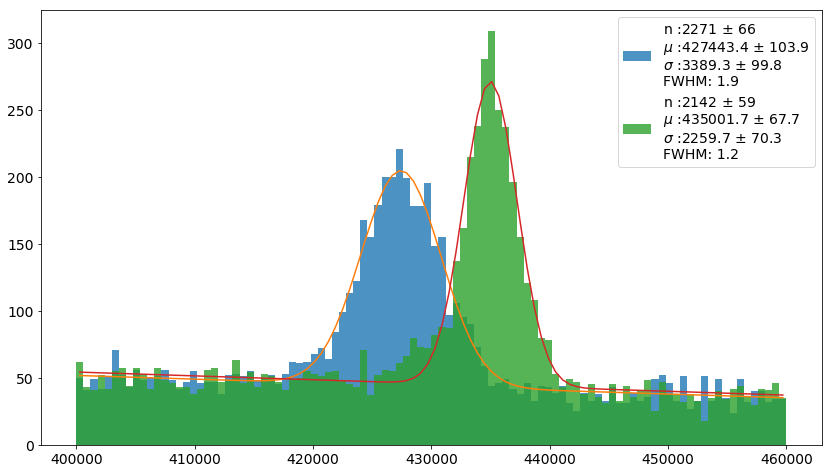

In [202]:
canvas_efit(esum.e , (400e3, 460e3), alpha = 0.8)
canvas_efit(esum.ee, (400e3, 460e3), alpha = 0.8)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


Optimization terminated successfully.
         Current function value: 5627.614535
         Iterations: 22
         Function evaluations: 2400
Optimization terminated successfully.
         Current function value: 6892.232402
         Iterations: 17
         Function evaluations: 2068


1.2158812958085357

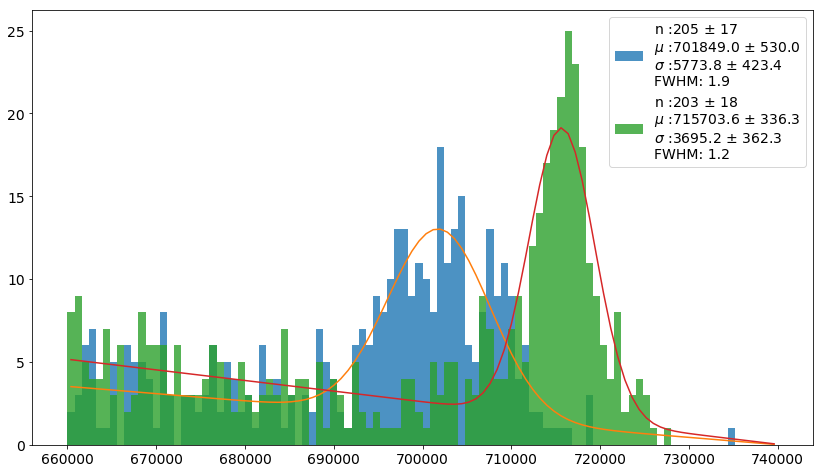

In [203]:
canvas_efit(esum.e , (660e3, 740e3), alpha = 0.8, nbins = 100)
canvas_efit(esum.ee, (660e3, 740e3), alpha = 0.8, nbins = 100)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 141777.098469
         Iterations: 16
         Function evaluations: 1337
Optimization terminated successfully.
         Current function value: 162661.131695
         Iterations: 16
         Function evaluations: 1280


1.3858258716084417

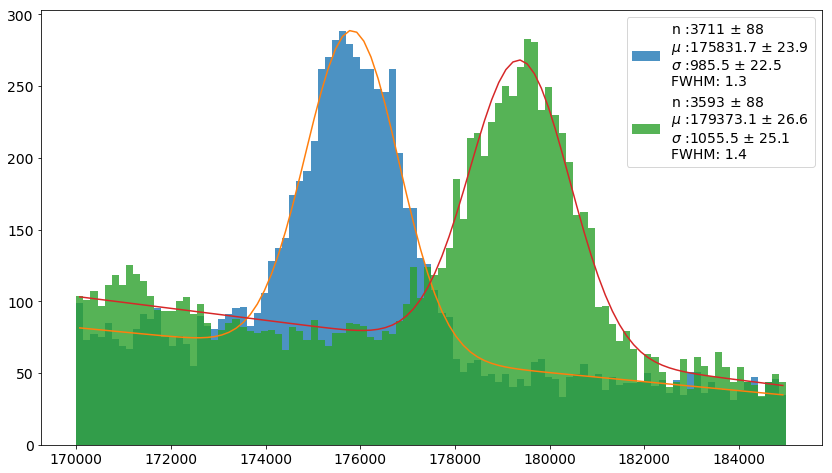

In [204]:
canvas_efit(esum.e , (170e3, 185e3), alpha = 0.8)
canvas_efit(esum.ee, (170e3, 185e3), alpha = 0.8)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 241282.663545
         Iterations: 21
         Function evaluations: 1629
xhat  [1.75072269e+04 1.87577325e+03 4.36403889e-07 7.66202694e+03
 1.58099665e+02]
7001.339819922658 8098.490267660321


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


Optimization terminated successfully.
         Current function value: 11902.342272
         Iterations: 16
         Function evaluations: 1806
xhat  [5.07650934e-09 1.05393365e+03 1.17428118e-06 7.39911288e+03
 1.95827631e+02]
7001.318579592047 8098.847658036487


array([5.07650934e-09, 1.05393365e+03, 1.17428118e-06, 7.39911288e+03,
       1.95827631e+02])

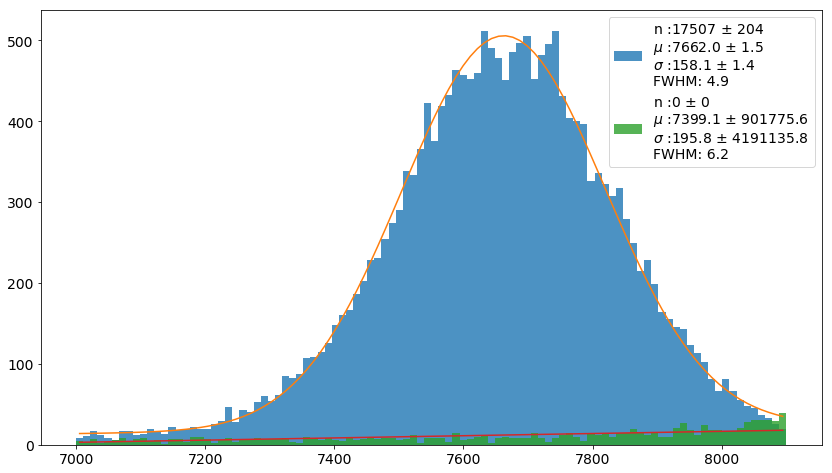

In [163]:
canvas_efit(esum.e , (7e3, 8.1e3), alpha = 0.8)
#canvas_efit(esum.ee, (7e3, 8.1e3), alpha = 0.8)

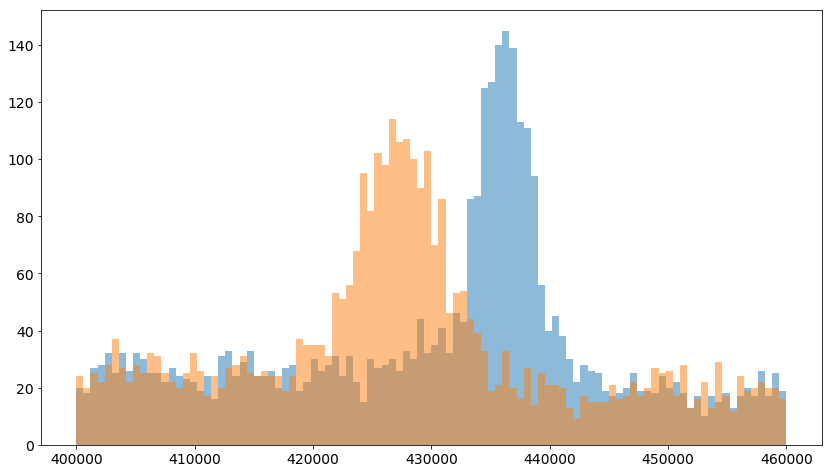

In [96]:
m = 0.15e3
ee = esum.e.values + m * esum.zsize.values
esum['ee'] = ee
plt.hist(ee    , 100, (400e3, 460e3), alpha = 0.5);
plt.hist(esum.e, 100, (400e3, 460e3), alpha = 0.5);

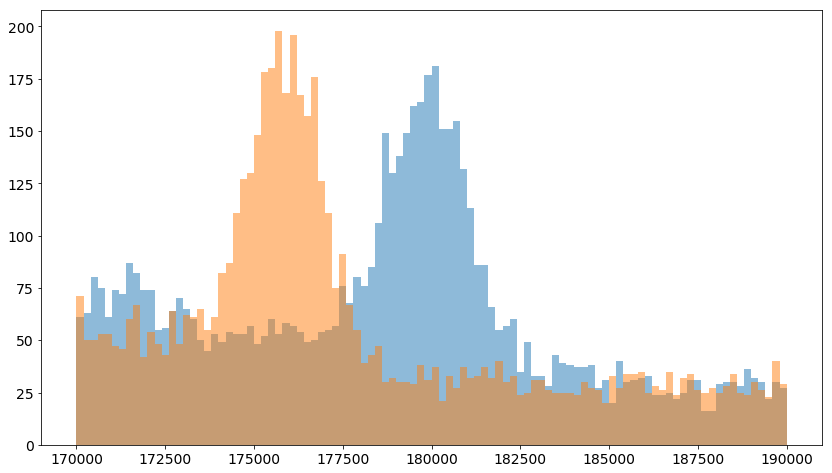

In [101]:
plt.hist(ee    , 100, (170e3, 190e3), alpha = 0.5);
plt.hist(esum.e, 100, (170e3, 190e3), alpha = 0.5);

In [ ]:
m = 0.15e3
ee = esum.e.values + m * esum.zsize.values
esum['ee'] = ee
plt.hist(ee    , 100, (650e3, 750e3), alpha = 0.5);
plt.hist(esum.e, 100, (650e3, 750e3), alpha = 0.5);

In [89]:
import csth.utils.photopeak_fit as phfit

In [91]:
esum = esums[0]
print(len(esum))
for i, iesum in enumerate(esums[1:]):
    esum = esum.append(iesum, ignore_index = True)
print(len(esum))

330298
330298


In [92]:
def canvas_esigma(ee, erange, nbins= 100, tag='', alpha = 0.5):
    e0, e1 = erange
    dssel = in_range(ee, e0, e1)
    es    = ee[dssel]
    n     = np.sum(dssel)
    mu    = np.mean(es)
    sigma = np.std(es)
    mslope = 0.
    f      = 0.5
    x0     = np.array([n/2, n/2, mslope, mu, sigma])
    
    res, cov = phfit.pkfit(es, (e0, e1), x0)
    xhat = res.x
    print('xhat ', xhat)
    nug, nup, bhat, muhat, sighat = xhat[0], xhat[1], xhat[2], xhat[3], xhat[4]
    snug, snup, sb, smu, ssig = [np.sqrt(cov[i][i]) for i in range(5)
    
    s  = 'n :'+str(int(nug))+' $\pm$' + str(int(snug))+'\n'
    s += '$\mu$ :'+ "{0:.1f}".format(muhat) +'\n'
    s += '$\sigma$ :'+ "{0:.1f}".format(sighat)
    
    
    #mushat = efit.extll_fit_pol1dgaus(es, e0, e1)
    print(es.min(), es.max())
    ys, xs, _ = plt.hist(es, nbins, range = erange, label = s)
    xs = 0.5*(xs[1:] + xs[:-1])

    ys = phfit.pkpdf(xs, xhat, erange)
    dx = xs[1] - xs[0]
    plt.plot(xs, ys * dx * n)
    plt.legend()
    
    #print(xs)
    
    #plt.xlim(e0, e1)
    #dat = plot_extll_fit(es, e0, e1, mushat, tag = tag, alpha = alpha)
    return xhat

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 54903.043655
         Iterations: 17
         Function evaluations: 1753
xhat  [ 1.12509094e+03  2.35590946e+03 -1.12173956e-10  4.36139927e+05
  2.26143652e+03]
400103.4159577703 459977.9549321262


array([ 1.12509094e+03,  2.35590946e+03, -1.12173956e-10,  4.36139927e+05,
        2.26143652e+03])

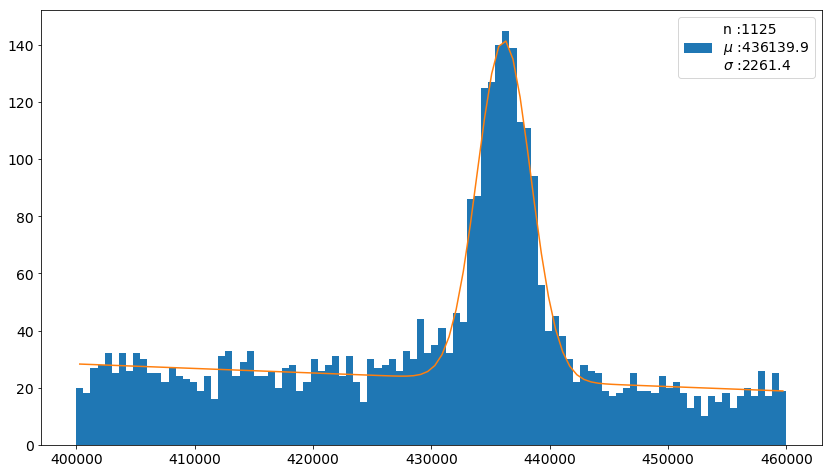

In [93]:
canvas_esigma(esum.ee, (400e3, 460e3))

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2365.129771
         Iterations: 10
         Function evaluations: 1120
xhat  [ 9.30658744e+01  7.59341253e+01 -5.46509029e-10  7.17552443e+05
  3.35619311e+03]
680348.0413137055 728689.7503749739


array([ 9.30658744e+01,  7.59341253e+01, -5.46509029e-10,  7.17552443e+05,
        3.35619311e+03])

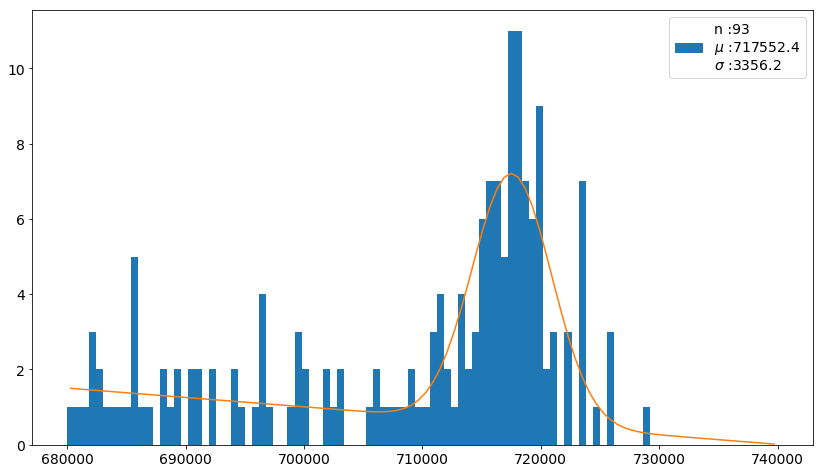

In [95]:
canvas_esigma(esum.ee, (680e3, 740e3))

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 773.573806
         Iterations: 11
         Function evaluations: 1204
xhat  [7.25169976e+01 7.48272367e+00 1.65289190e-06 7.63855807e+03
 1.51497741e+02]
7279.299094172613 8170.009982694419


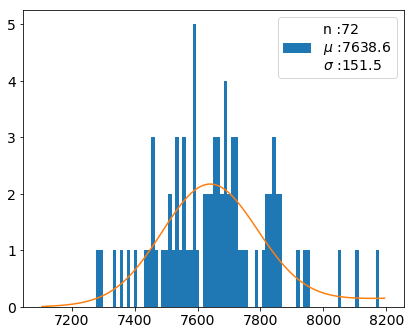

In [63]:
tag = '6482'
fig = plt.figure(figsize= (15, 12))
plt.subplot(2, 2, 1)
canvas_esigma(esum.e, (7.1e3, 8.2e3), tag = tag, alpha = 1.);
#plt.subplot(2, 2, 2)
#canvas_esigma(esum.e, (170e3, 180e3), tag = tag, alpha = 1.);
#plt.subplot(2, 2, 3)
#canvas_esigma(esum.e, (400e3, 450e3), tag = tag, alpha = 1.);
#plt.subplot(2, 2, 4)
#canvas_esigma(esum.e, (650e3, 730e3), tag = tag, alpha = 1.);

In [32]:
x, y = esum.x, esum.y
esum['r']    = np.sqrt(x*x + y*y )
esum['zmin'] = esum.zmax - esum.zsize
fidsel = esum.peak == 0

esum = esum[fidsel]
#fidsel = (esum.r < 1600) & (esum.zmin > 175.) & (esum.zmax < 375)

#esum0 = esum[fidsel]

## Studying E vs Z

In [117]:
def str_stats(xs, xrange = None, sig="{0:.3f}"):
    xrange = (xs.min(), xs.max()) if xrange is None else xrange
    xsel = in_range(xs, *xrange)
    xxs = xs[xsel]
    n, mu, std  = len(xxs), np.mean(xxs), np.std(xxs)
    s  = 'entries : '+ str(n)         + '\n'
    s += 'mean    : '+ sig.format(mu) +'\n'
    s += 'mean    : '+ sig.format(std)
    return s

def var_vs_var(esum, xname, xrange, yname, yrange, nbins = 50, sel = None, alpha = 0.01):

    xvar = esum[xname]
    yvar = esum[yname]

    xsel = (in_range(xvar, *xrange)) & (in_range(yvar, *yrange))
    if (sel is not None):
        xsel = xsel & sel
    
    c = hst.Canvas(1, 2)
    c(1)
    plt.scatter(xvar[xsel], yvar[xsel], alpha = alpha)
    xs, ys, eys = fitf.profileX(xvar[xsel], yvar[xsel], nbins)
    plt.errorbar(xs, ys, yerr=eys, fmt='*', c='black', alpha = 0.3) 
    xs, ys, eys = fitf.profileX(yvar[xsel], xvar[xsel], nbins)
    plt.errorbar(ys, xs, xerr=eys, fmt='+', c='red', alpha = 0.3) 
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.ylim(*yrange)
    plt.grid()
    c(2)
    s = str_stats(yvar[xsel])
    plt.hist(yvar[xsel], nbins, yrange, label = s)
    plt.xlabel(yname)
    plt.legend()
    plt.grid()
    
    plt.tight_layout()


In [107]:
eax   = hst.Vaxis((0.   , 750e3), 200)
ecsax = hst.Vaxis((150e3, 185e3), 100)
edsax = hst.Vaxis((410e3, 445e3), 100)
etlax = hst.Vaxis((660e3, 730e3),  20)

esel  = in_range(esum.e, *eax.range)
cssel = in_range(esum.e, *ecsax.range)
dssel = in_range(esum.e, *edsax.range)
tlsel = in_range(esum.e, *etlax.range)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


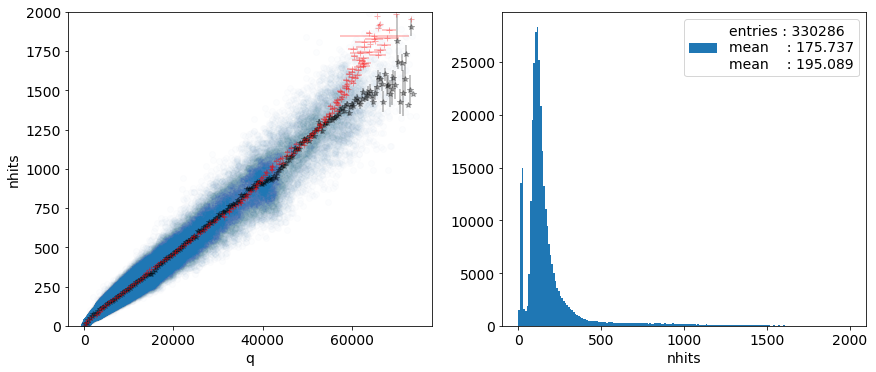

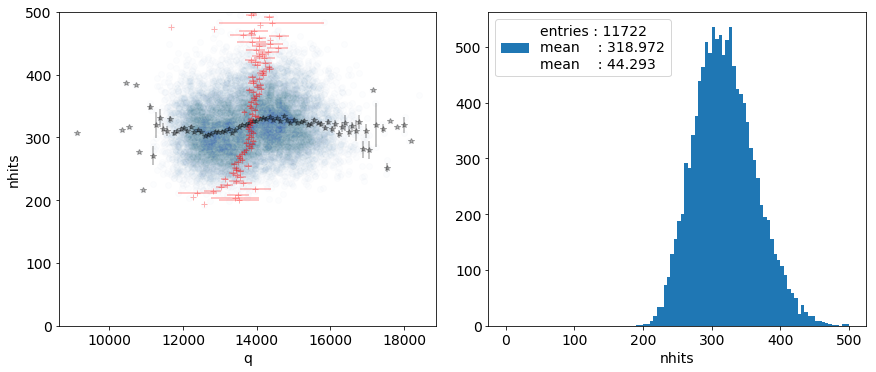

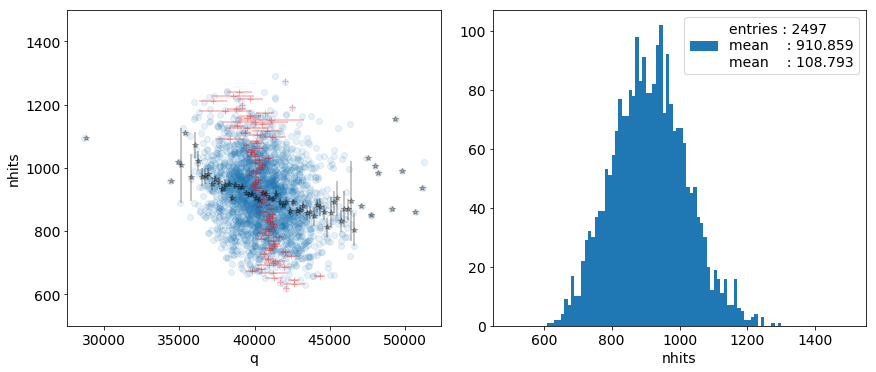

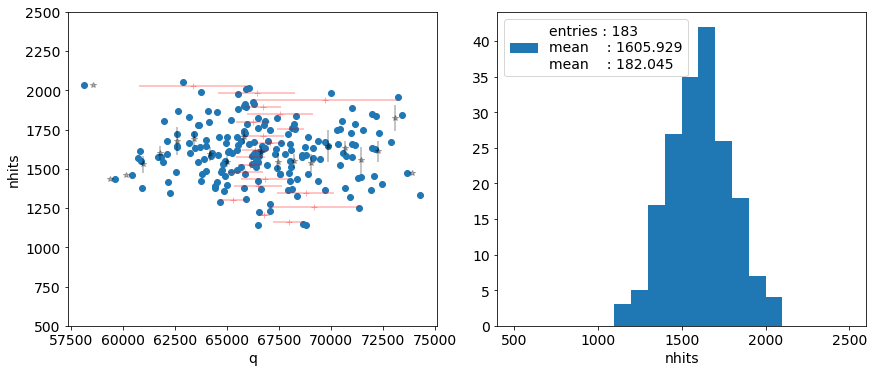

In [111]:
f = 2.
var_vs_var(esum, 'q', (0., 80e3), 'nhits', (0.  , 2000), nbins = eax.nbins  , sel = esel , alpha = f*0.005)
var_vs_var(esum, 'q', (0., 80e3), 'nhits', (0.  ,  500), nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'q', (0., 80e3), 'nhits', (500., 1500), nbins = edsax.nbins, sel = dssel, alpha = f*0.05)
var_vs_var(esum, 'q', (0., 80e3), 'nhits', (500., 2500), nbins = etlax.nbins, sel = tlsel, alpha = f*0.5)

## Z-size

In [58]:
m = 0.15e3
ee = esum.e + m * esum.zsize
esum['ee'] = ee

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


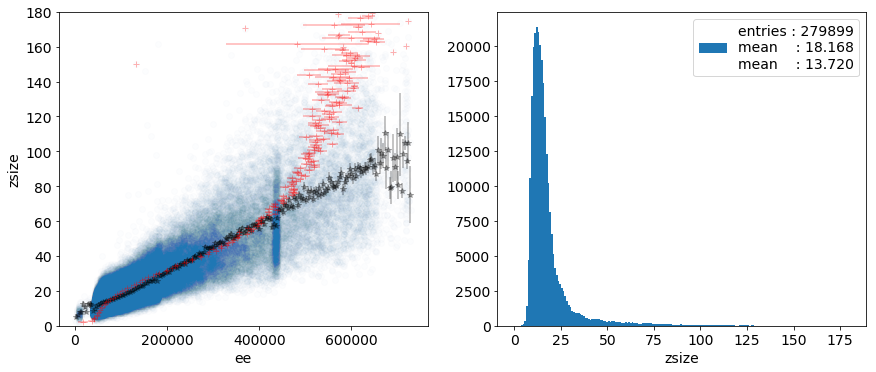

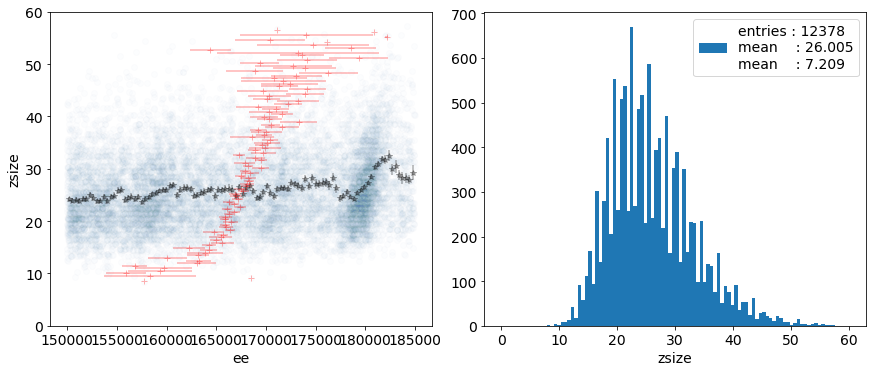

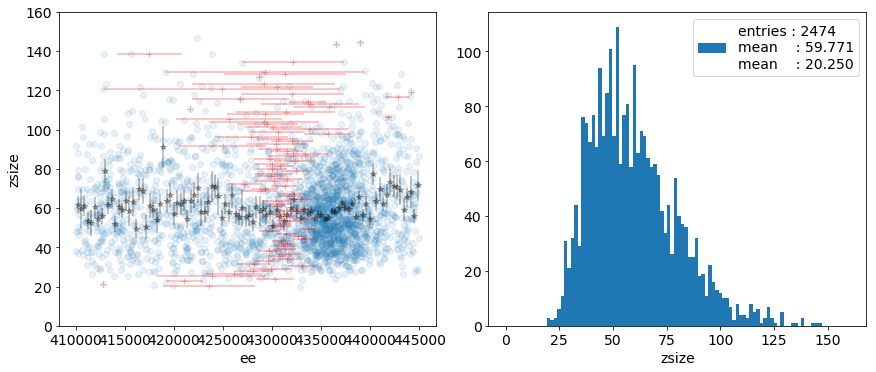

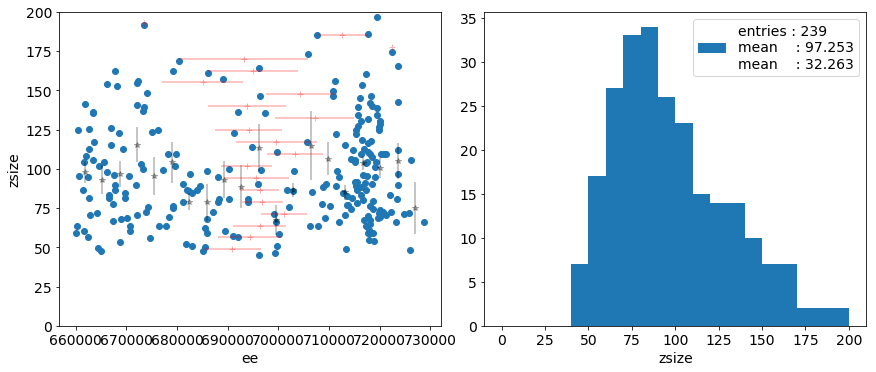

In [59]:
f = 2.
var_vs_var(esum, 'ee', eax.range  , 'zsize', (0., 180), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'ee', ecsax.range, 'zsize', (0.,  60), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'ee', edsax.range, 'zsize', (0., 160), nbins = edsax.nbins, alpha = f*0.05)
var_vs_var(esum, 'ee', etlax.range, 'zsize', (0., 200), nbins = etlax.nbins, alpha = f*0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


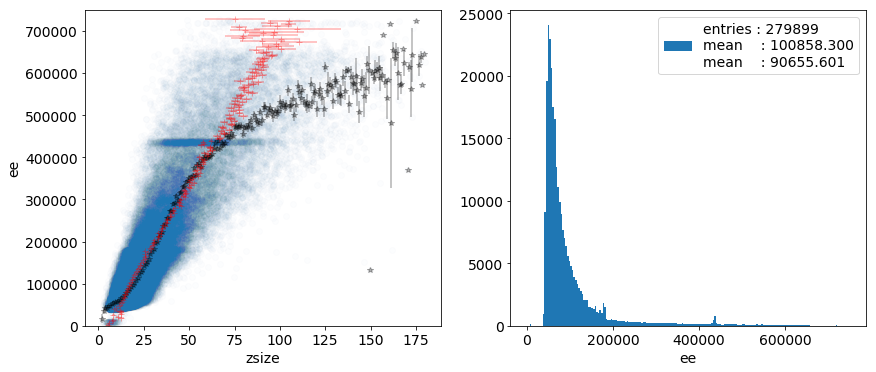

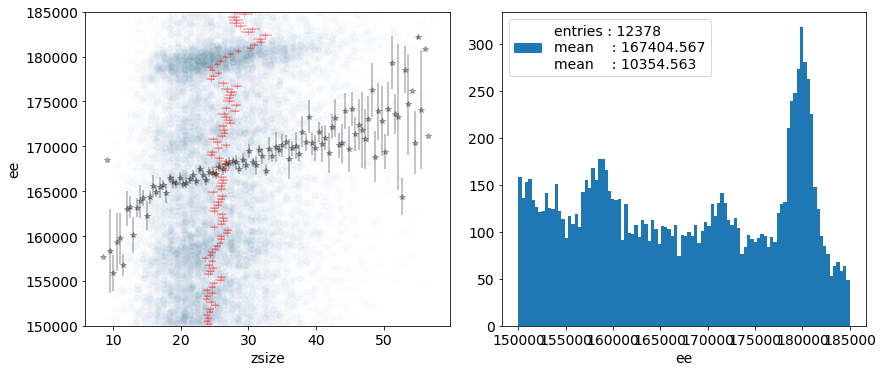

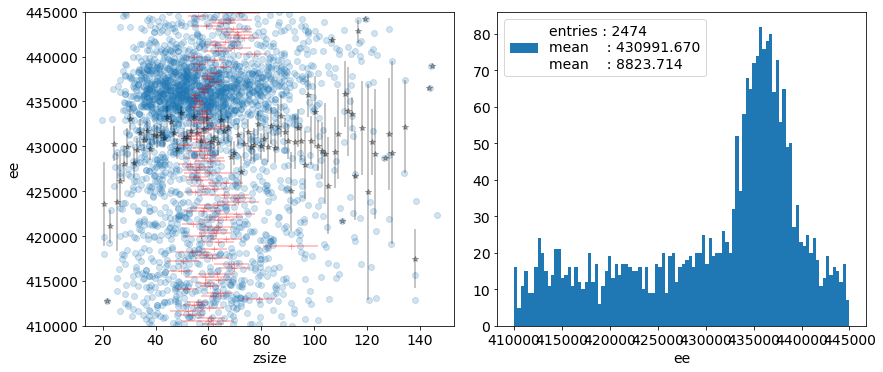

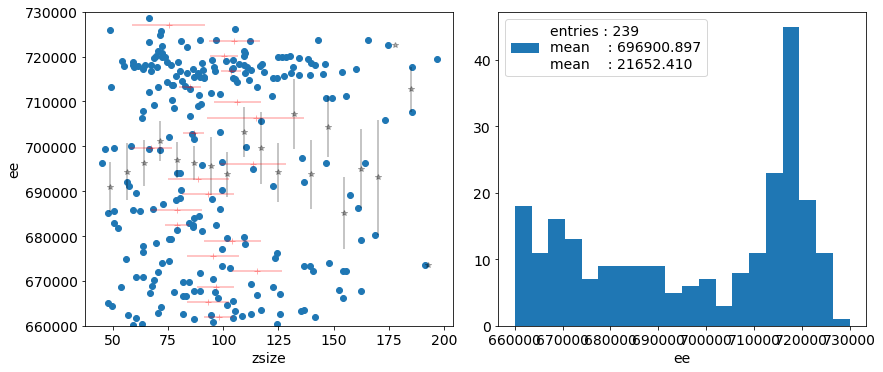

In [61]:
var_vs_var(esum, 'zsize', (0., 180), 'ee',   eax.range, nbins =   eax.nbins, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  60), 'ee', ecsax.range, nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'ee', edsax.range, nbins = edsax.nbins, alpha = f*0.1)
var_vs_var(esum, 'zsize', (0., 200), 'ee', etlax.range, nbins = etlax.nbins, alpha = f*0.5)

## N-hits

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


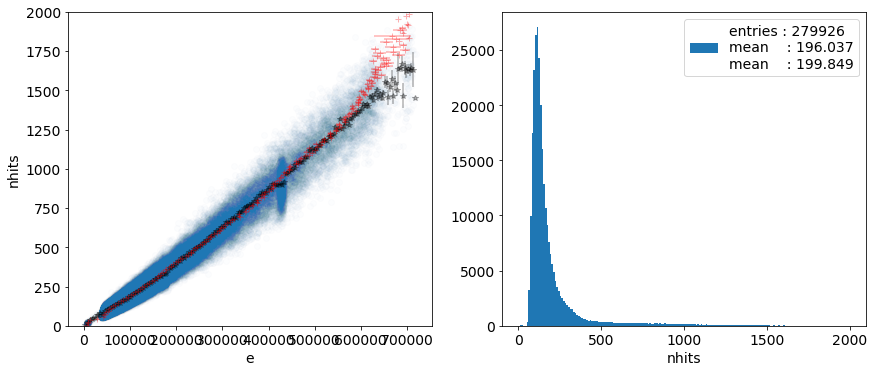

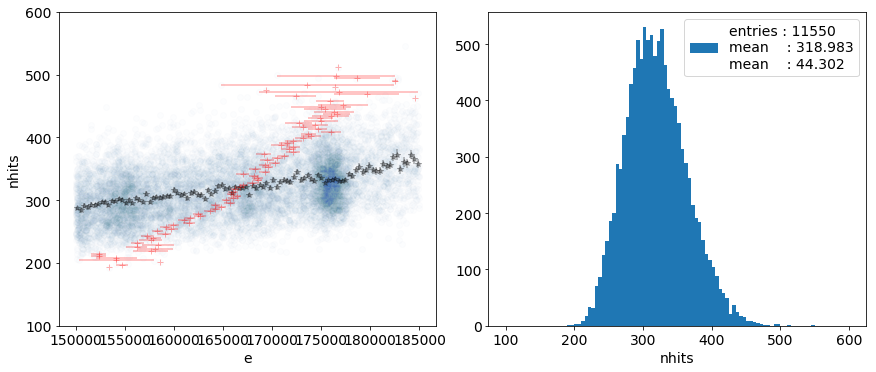

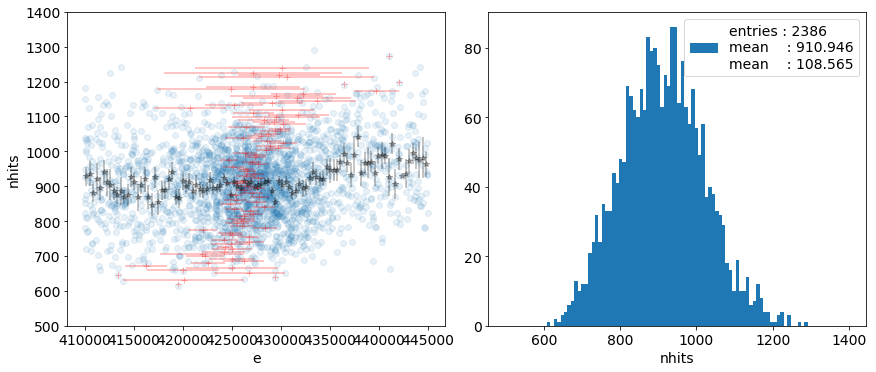

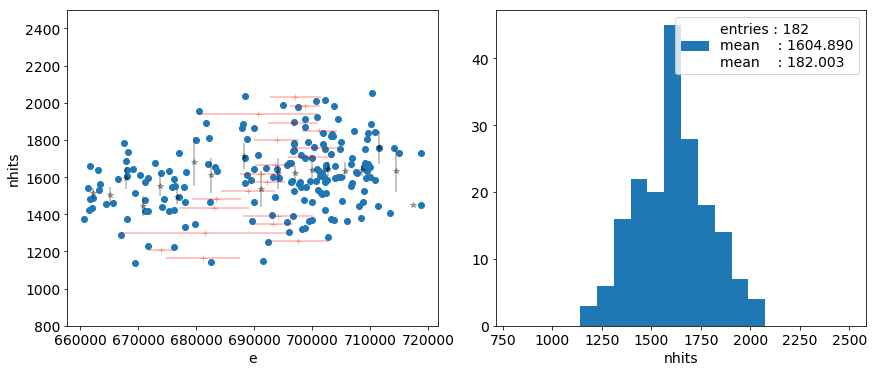

In [39]:
var_vs_var(esum, 'e', eax.range  , 'nhits', (   0, 2000), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'e', ecsax.range, 'nhits', ( 100,  600), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'e', edsax.range, 'nhits', ( 500, 1400), nbins = edsax.nbins, alpha = f*0.05)
var_vs_var(esum, 'e', etlax.range, 'nhits', ( 800, 2500), nbins = etlax.nbins, alpha = f*0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


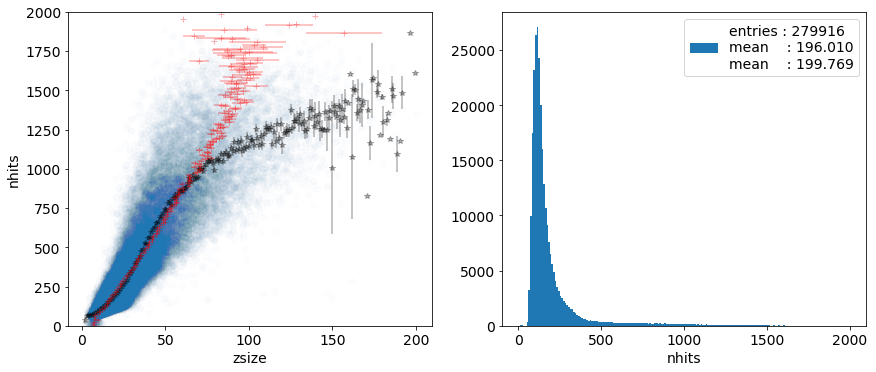

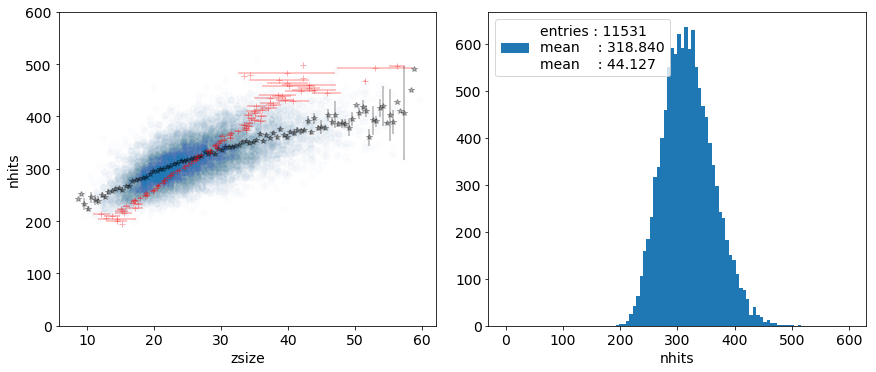

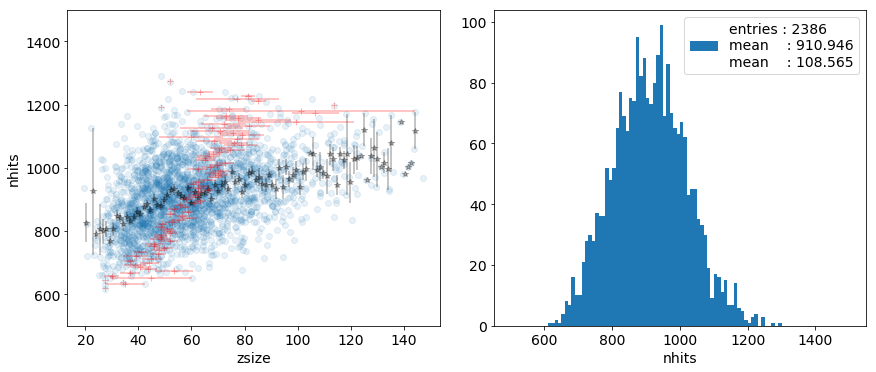

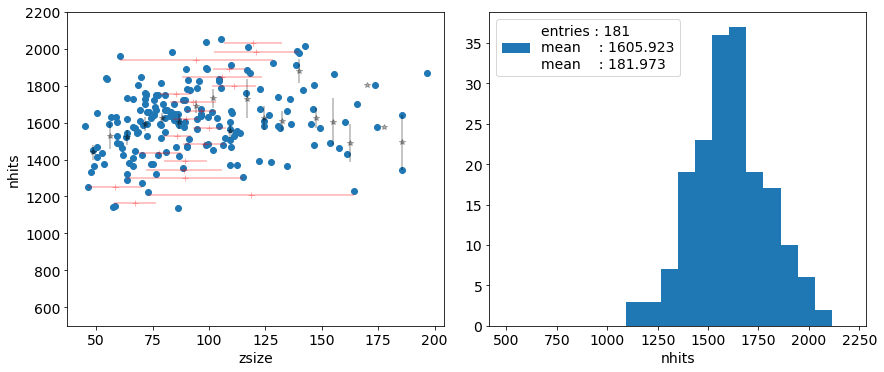

In [41]:
var_vs_var(esum, 'zsize', (0., 200), 'nhits', (0., 2000) , nbins =   eax.nbins, sel = esel , alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  60), 'nhits', (0., 600 ) , nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'nhits', (500, 1500), nbins = edsax.nbins, sel = dssel, alpha = f*0.05)
var_vs_var(esum, 'zsize', (0., 200), 'nhits', (500, 2200), nbins = etlax.nbins, sel = tlsel, alpha = f*0.5)

## Zmin

In [42]:
esum['zmin'] = esum.zmax - esum.zsize

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


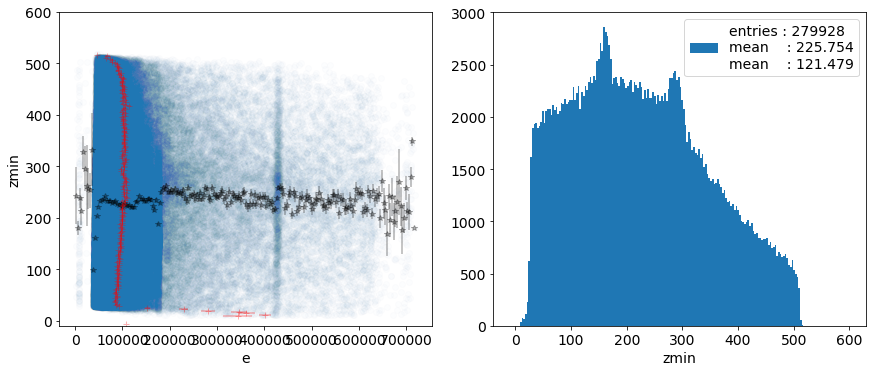

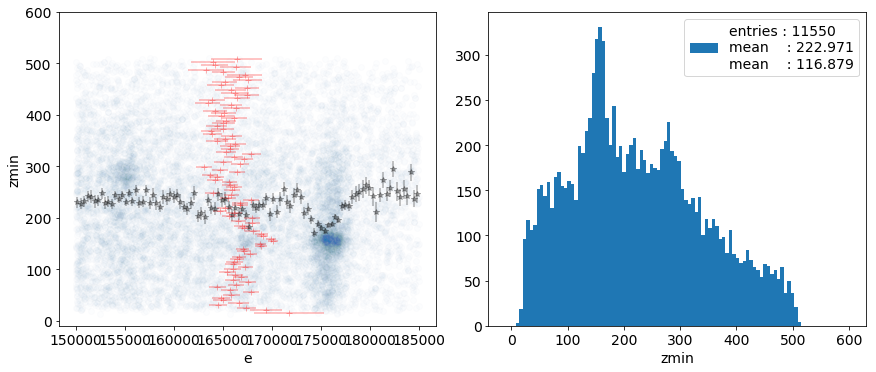

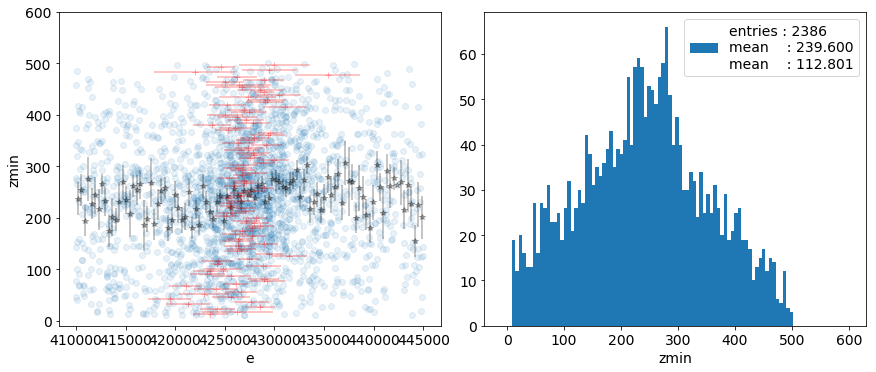

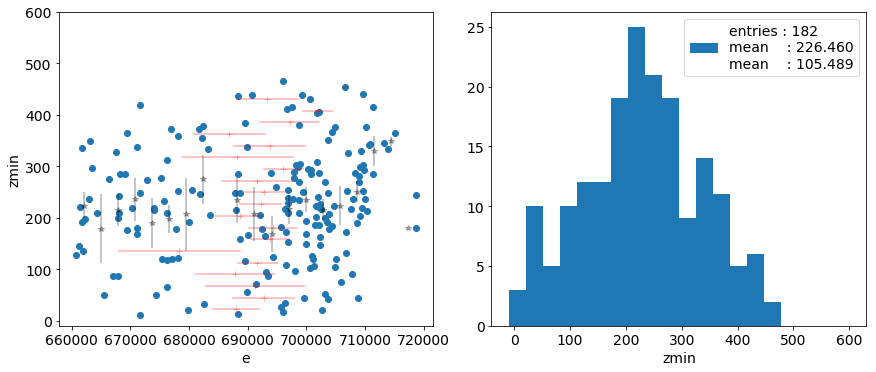

In [43]:
var_vs_var(esum, 'e', eax.range  , 'zmin', (-10., 600), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'e', ecsax.range, 'zmin', (-10., 600), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'e', edsax.range, 'zmin', (-10., 600), nbins = edsax.nbins, alpha = f*0.05)
var_vs_var(esum, 'e', etlax.range, 'zmin', (-10., 600), nbins = etlax.nbins, alpha = f*0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


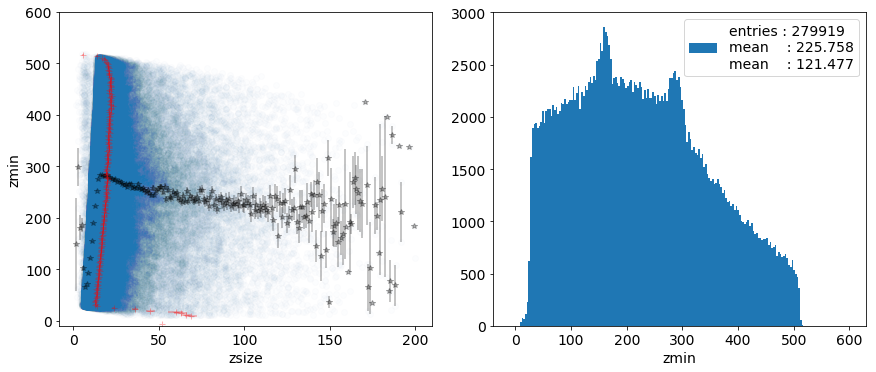

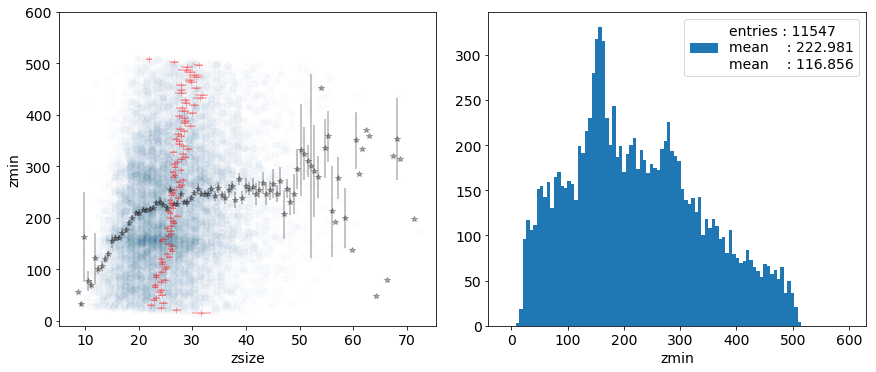

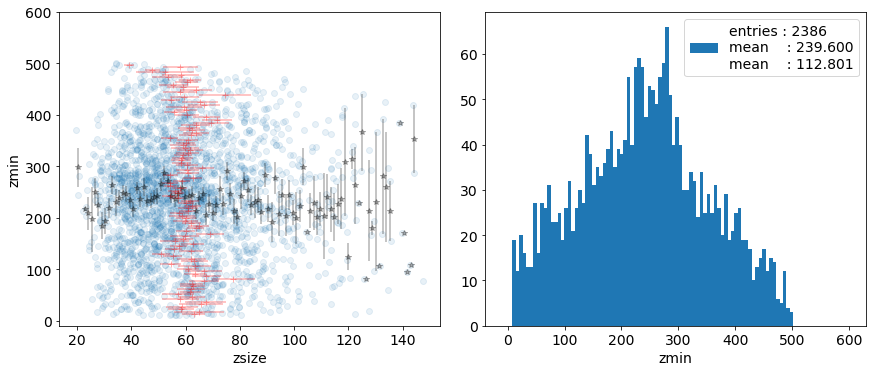

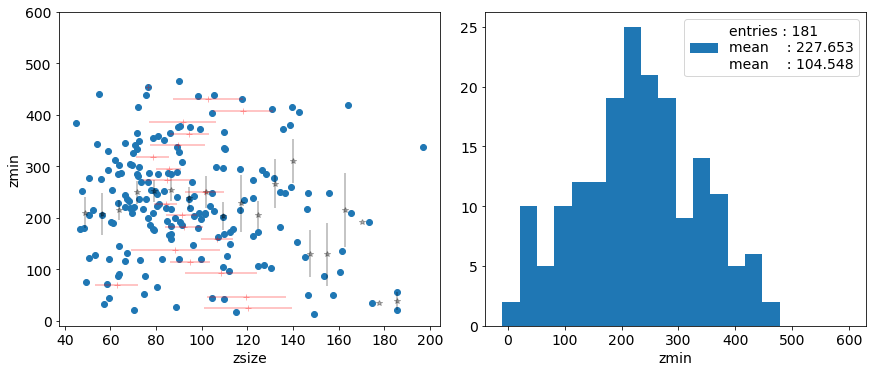

In [45]:
var_vs_var(esum, 'zsize', (0., 200), 'zmin', (-10, 600), nbins =   eax.nbins, sel = esel , alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'zmin', (-10, 600), nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'zmin', (-10, 600), nbins = edsax.nbins, sel = dssel, alpha = f*0.05)
var_vs_var(esum, 'zsize', (0., 200), 'zmin', (-10, 600), nbins = etlax.nbins, sel = tlsel, alpha = f*0.5)

## Zmax

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


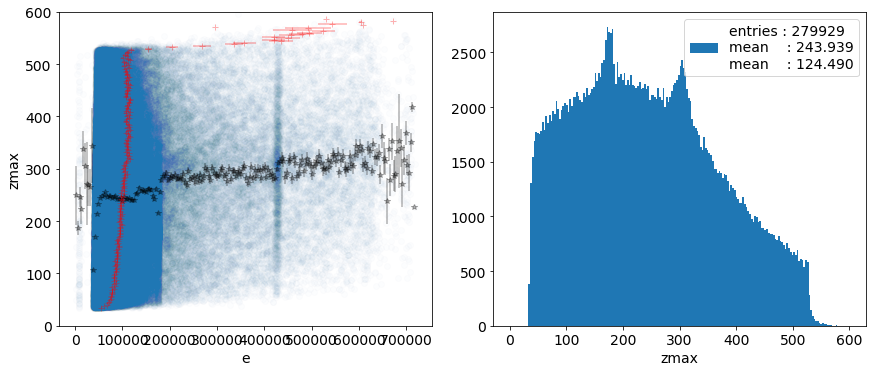

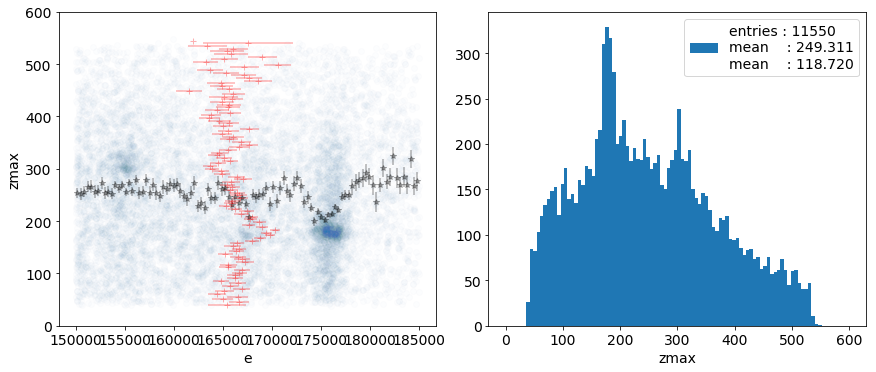

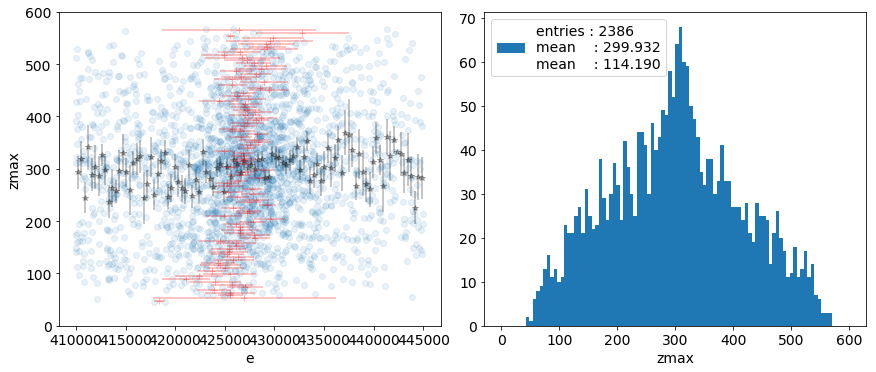

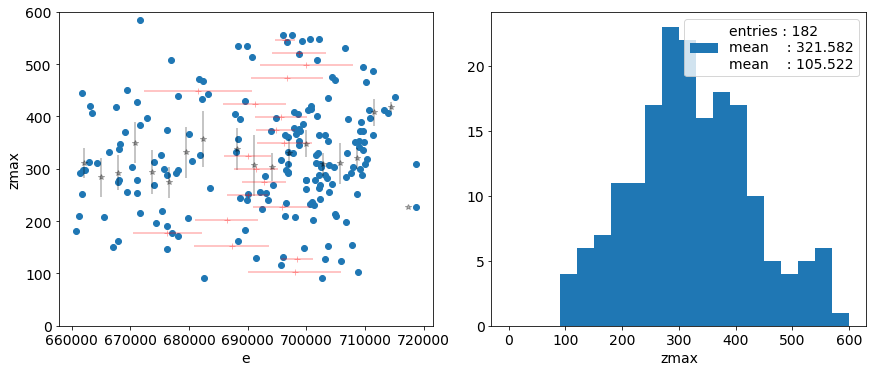

In [46]:
var_vs_var(esum, 'e', eax.range  , 'zmax', (0., 600), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'e', ecsax.range, 'zmax', (0., 600), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'e', edsax.range, 'zmax', (0., 600), nbins = edsax.nbins, alpha = f*0.05)
var_vs_var(esum, 'e', etlax.range, 'zmax', (0., 600), nbins = etlax.nbins, alpha = f*0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


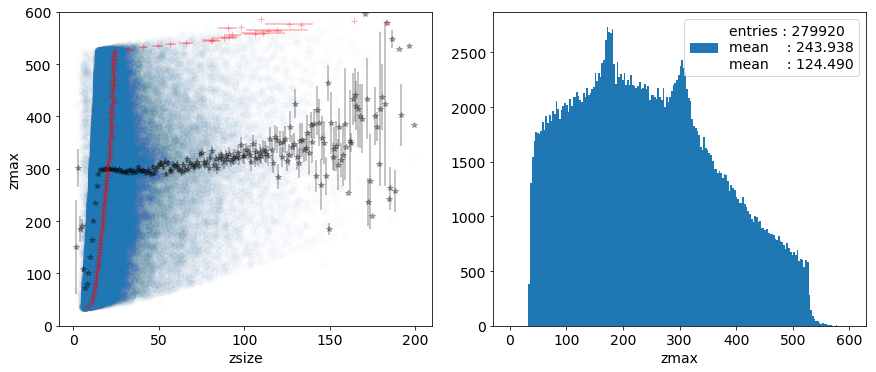

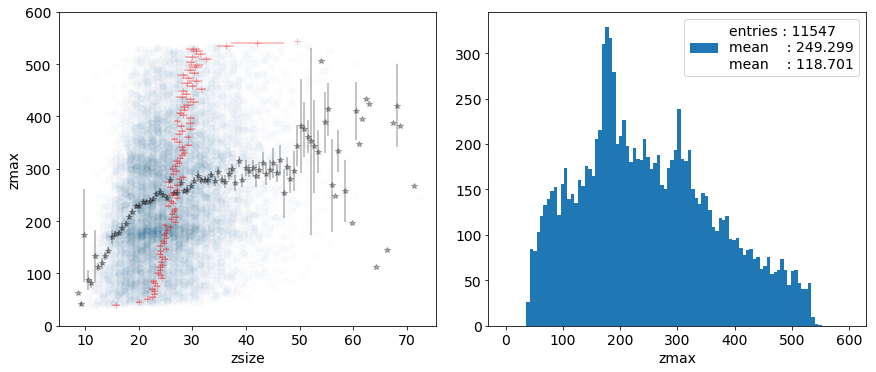

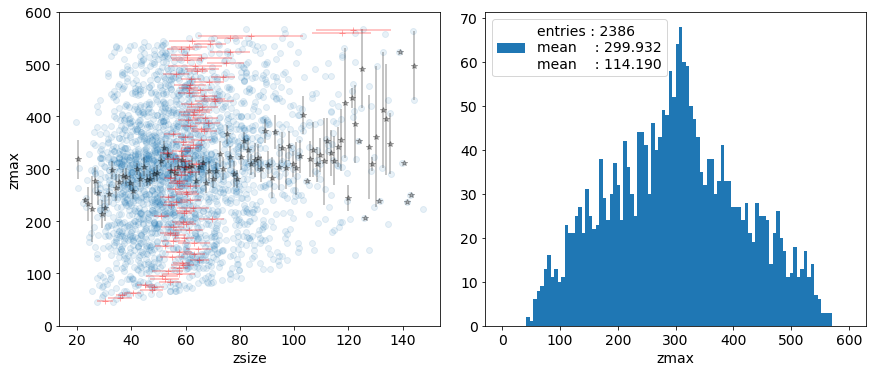

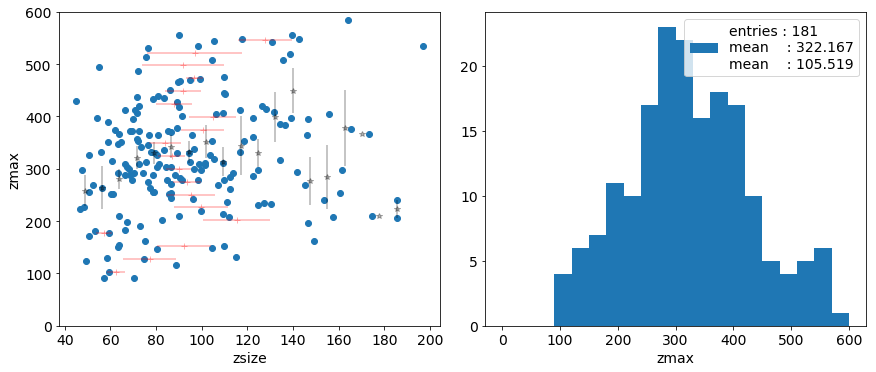

In [47]:
var_vs_var(esum, 'zsize', (0., 200), 'zmax', (0, 600), nbins =   eax.nbins, sel = esel , alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'zmax', (0, 600), nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'zmax', (0, 600), nbins = edsax.nbins, sel = dssel, alpha = f*0.05)
var_vs_var(esum, 'zsize', (0., 200), 'zmax', (0, 600), nbins = etlax.nbins, sel = tlsel, alpha = f*0.5)

## Z

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


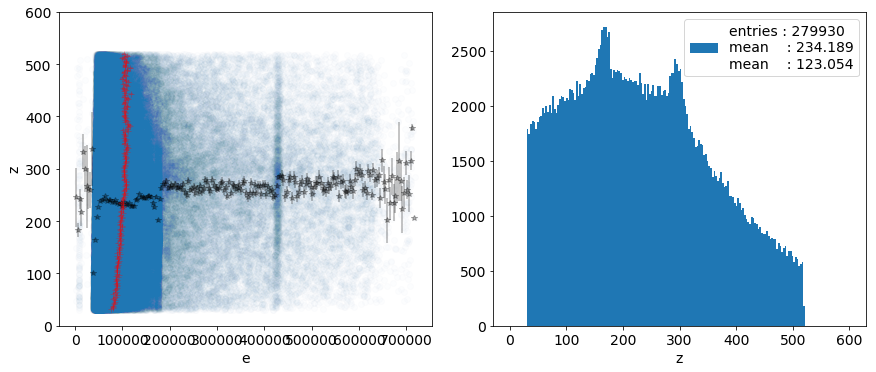

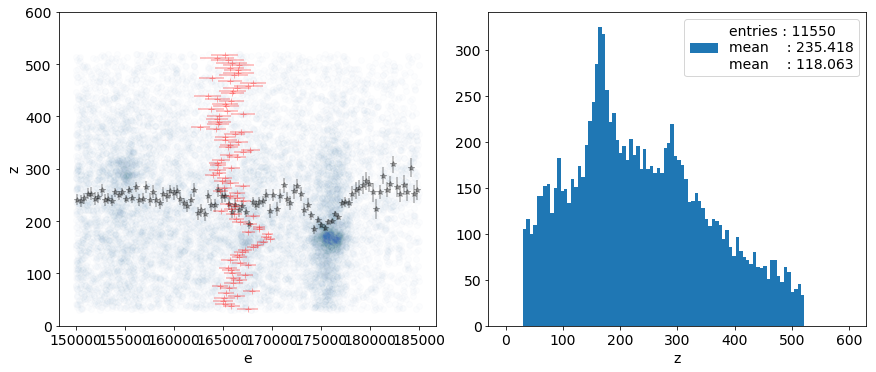

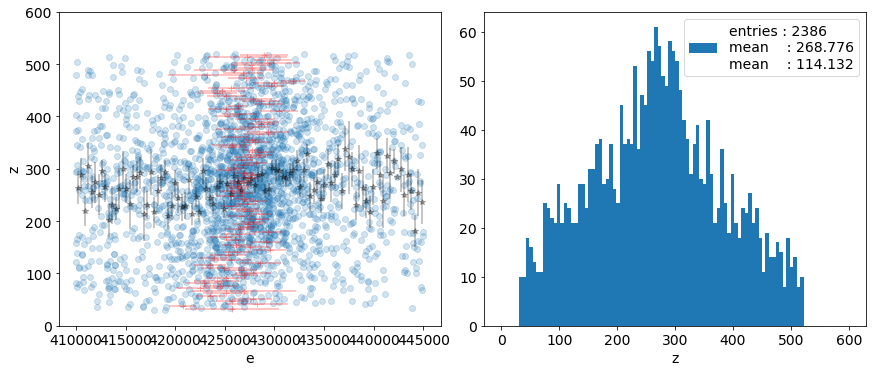

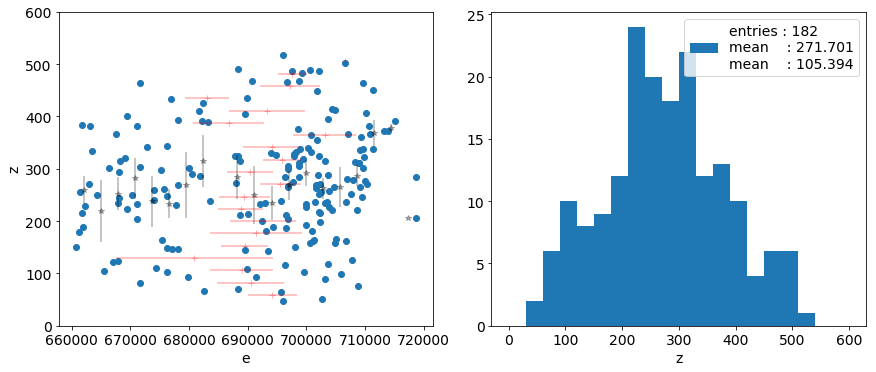

In [48]:
var_vs_var(esum, 'e', eax.range  , 'z', (0., 600), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'e', ecsax.range, 'z', (0., 600), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'e', edsax.range, 'z', (0., 600), nbins = edsax.nbins, alpha = f*0.1)
var_vs_var(esum, 'e', etlax.range, 'z', (0., 600), nbins = etlax.nbins, alpha = f*0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


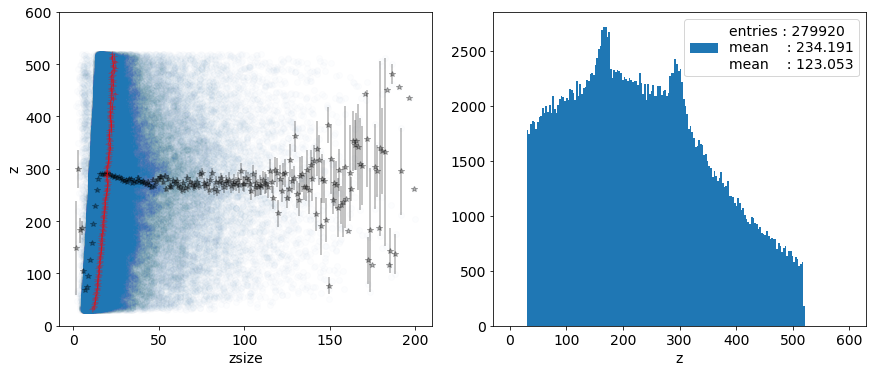

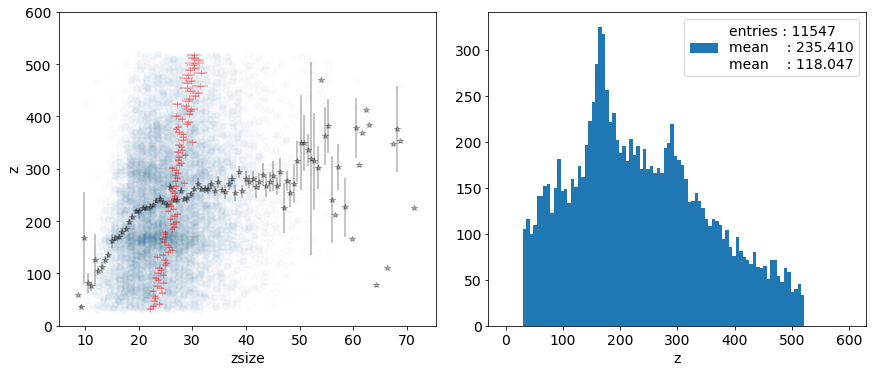

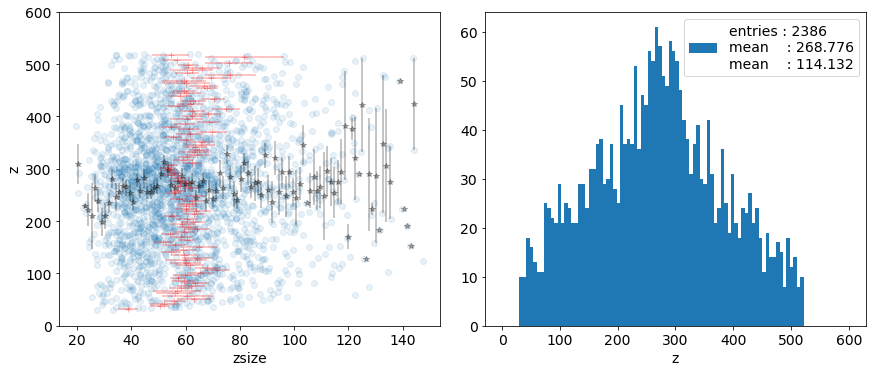

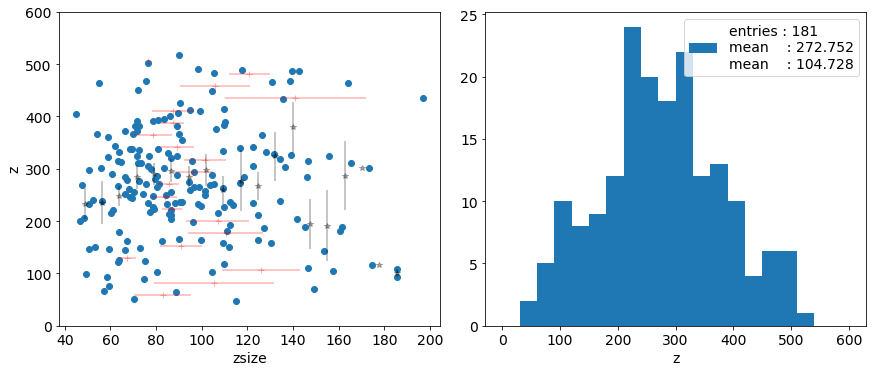

In [49]:
var_vs_var(esum, 'zsize', (0., 200), 'z', (0, 600), nbins =   eax.nbins, sel = esel , alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'z', (0, 600), nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'z', (0, 600), nbins = edsax.nbins, sel = dssel, alpha = f*0.05)
var_vs_var(esum, 'zsize', (0., 200), 'z', (0, 600), nbins = etlax.nbins, sel = tlsel, alpha = f*0.5)

## Z1

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'z1', (0., 600), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'e', ecsax.range, 'z1', (0., 600), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'e', edsax.range, 'z1', (0., 600), nbins = edsax.nbins, alpha = f*0.05)
var_vs_var(esum, 'e', etlax.range, 'z1', (0., 600), nbins = etlax.nbins, alpha = f*0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'z1', (0, 600), nbins =   eax.nbins, sel = esel , alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'z1', (0, 600), nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'z1', (0, 600), nbins = edsax.nbins, sel = dssel, alpha = f*0.5)
var_vs_var(esum, 'zsize', (0., 200), 'z1', (0, 600), nbins = etlax.nbins, sel = tlsel, alpha = f*0.5)

## Z2

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'z2', (0., 600), nbins = eax.nbins  , alpha = f*0.005)
var_vs_var(esum, 'e', ecsax.range, 'z2', (0., 600), nbins = ecsax.nbins, alpha = f*0.005)
var_vs_var(esum, 'e', edsax.range, 'z2', (0., 600), nbins = edsax.nbins, alpha = f*0.05)
var_vs_var(esum, 'e', etlax.range, 'z2', (0., 600), nbins = etlax.nbins, alpha = f*0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'z2', (0, 600), nbins =   eax.nbins, sel = esel , alpha = f*0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'z2', (0, 600), nbins = ecsax.nbins, sel = cssel, alpha = f*0.005)
var_vs_var(esum, 'zsize', (0., 150), 'z2', (0, 600), nbins = edsax.nbins, sel = dssel, alpha = f*0.05)
var_vs_var(esum, 'zsize', (0., 200), 'z2', (0, 600), nbins = etlax.nbins, sel = tlsel, alpha = f+0.5)

## t0

In [ ]:
var_vs_var(esum, 'e', eax.range  , 't0', (-10., 670), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 't0', (-10., 670), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 't0', (-10., 670), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 't0', (-10., 670), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 't0', (-10, 670), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 't0', (-10, 670), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 't0', (-10, 670), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 't0', (-10, 670), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## S1

In [ ]:
var_vs_var(esum, 'e', eax.range  , 's1e', (-10., 1e3), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 's1e', (-10., 3e2), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 's1e', (-10., 1e3), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 's1e', (-10., 1e3), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 's1e', (-10, 1000), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 's1e', (-10,  300), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 's1e', (-10,  800), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 's1e', (-10, 1000), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## time

In [ ]:
esum['t'] = (esum.time - esum.time.min())/3600000.

In [ ]:
plt.hist(esum.t, 100);

In [ ]:
var_vs_var(esum, 'e', eax.range  , 't', (0., 100.), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 't', (0., 100.), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 't', (0., 100.), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 't', (0., 100.), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 't', (0, 26), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 't', (0, 26), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 't', (0, 26), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 't', (0, 26), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## x

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'x', (-200., 200.), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'x', (-200., 200.), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'x', (-200., 200.), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'x', (-200., 200.), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'x', (-200, 200), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'x', (-200, 200), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'x', (-200, 200), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'x', (-200, 200), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## y 

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'y', (-200., 200.), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'y', (-200., 200.), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'y', (-200., 200.), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'y', (-200., 200.), nbins = etlax.nbins, alpha = 1.)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'y', (-200, 200), nbins =   eax.nbins, sel = esel , alpha = 0.01)
var_vs_var(esum, 'zsize', (0.,  80), 'y', (-200, 200), nbins = ecsax.nbins, sel = cssel, alpha = 0.02)
var_vs_var(esum, 'zsize', (0., 150), 'y', (-200, 200), nbins = edsax.nbins, sel = dssel, alpha = 0.1)
var_vs_var(esum, 'zsize', (0., 200), 'y', (-200, 200), nbins = etlax.nbins, sel = tlsel, alpha = 1.)

## R

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'r', (0., 220.), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'r', (0., 220.), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'r', (0., 220.), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'r', (0., 220.), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'r', (0, 220), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'r', (0, 220), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'r', (0, 220), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'r', (0, 220), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## q

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'q', ( 0e3,  80e3), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'q', ( 5e3,  20e3), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'q', (32e3,  48e3), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'q', (50e3,  80e3), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'q', (   0, 80e3), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'q', ( 5e3, 20e3), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'q', (25e3, 50e3), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'q', (50e3, 80e3), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## eh

In [120]:
esum['eq'] = esum.ee/esum.q

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


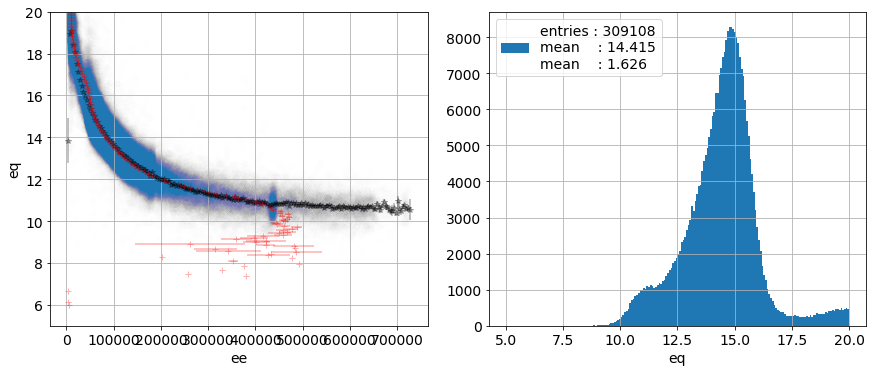

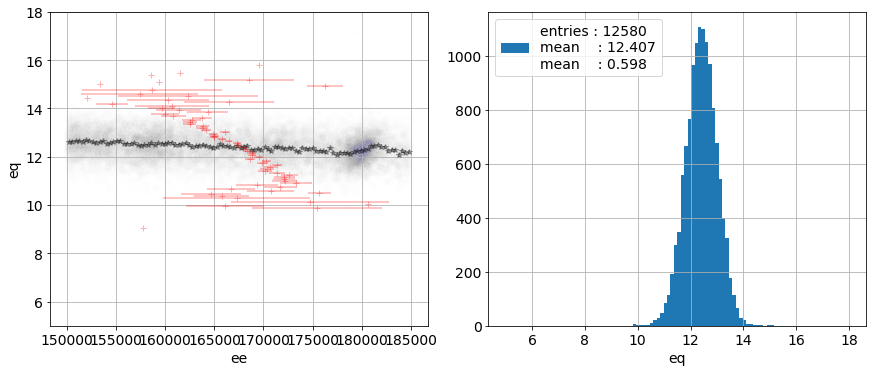

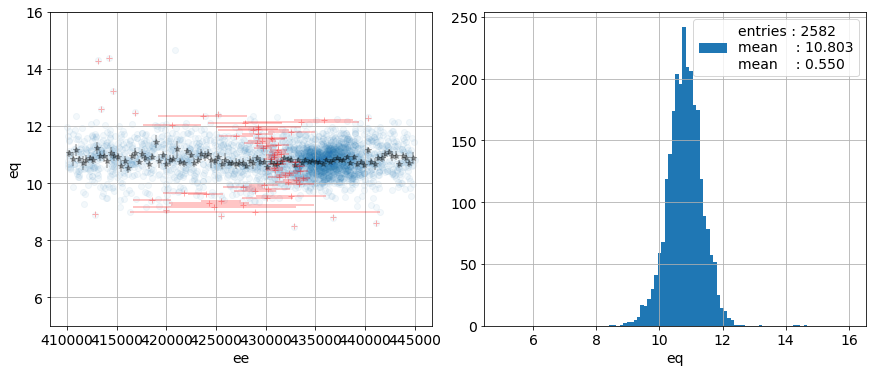

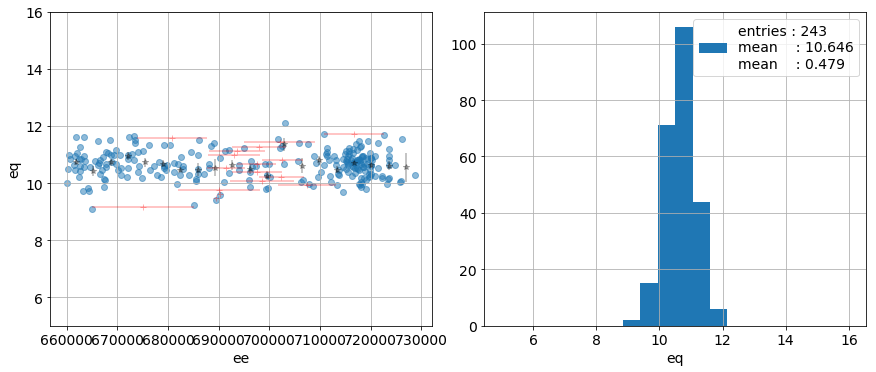

In [121]:
var_vs_var(esum, 'ee', eax.range  , 'eq', ( 5,  20), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'ee', ecsax.range, 'eq', ( 5,  18), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'ee', edsax.range, 'eq', ( 5,  16), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'ee', etlax.range, 'eq', ( 5,  16), nbins = etlax.nbins, alpha = 0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


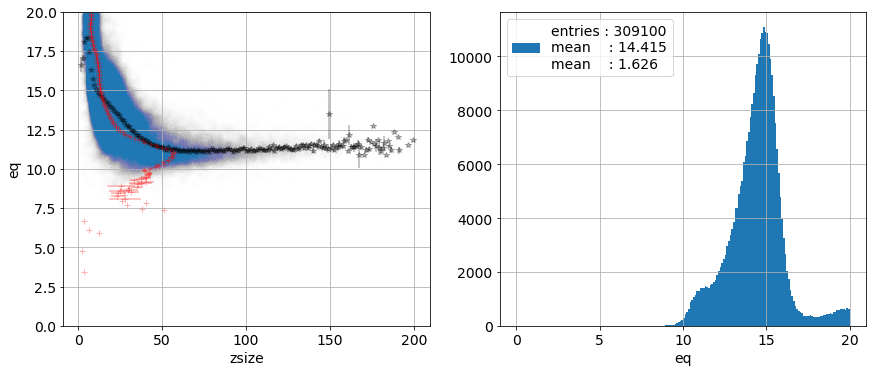

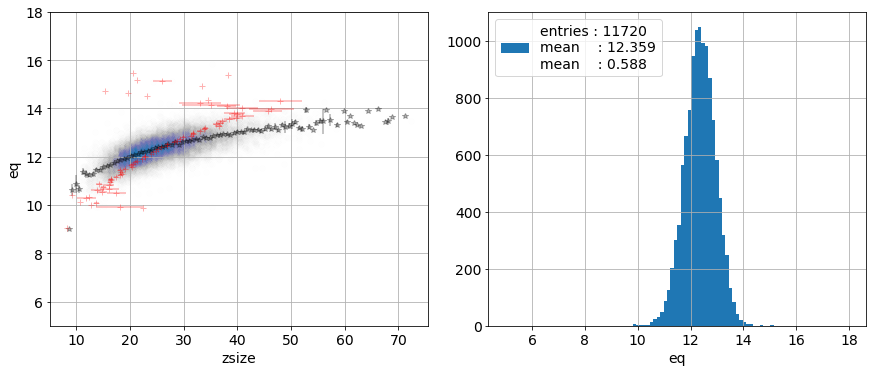

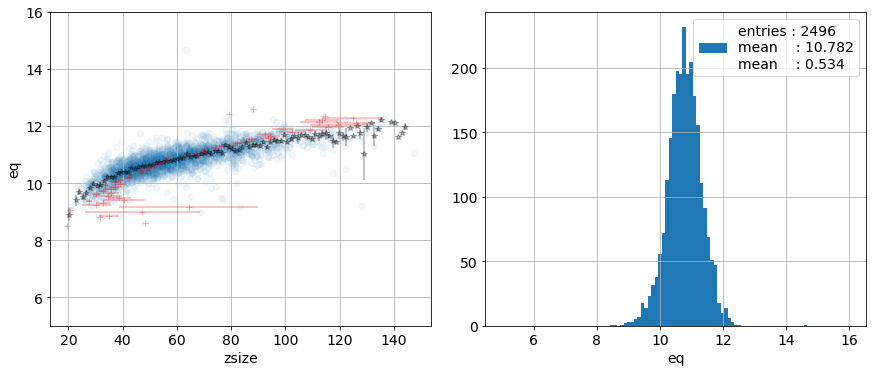

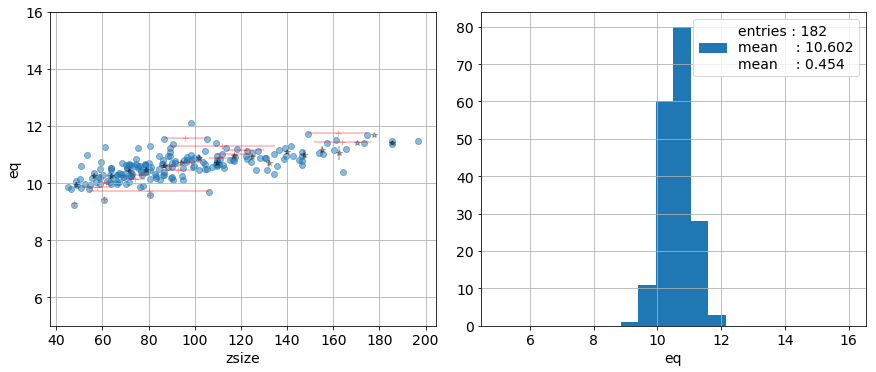

In [122]:
var_vs_var(esum, 'zsize', (0., 200), 'eq', ( 0, 20), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'eq', ( 5, 18), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'eq', ( 5, 16), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'eq', ( 5, 16), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## For-back

In [ ]:
esum['afb'] = (esum.ef - esum.eb)/(esum.ef + esum.eb)

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'afb', ( -1,  1), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'afb', ( -1,  1), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'afb', ( -1,  1), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'afb', ( -1,  1), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'afb', ( -1, 1), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'afb', ( -1, 1), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'afb', ( -1, 1), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'afb', ( -1, 1), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

# fz1

In [ ]:
esum['fz1'] = 2.*(esum.z1-esum.zu)/(esum.zsize)

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'fz1', ( -1,  1), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'fz1', ( -1,  1), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'fz1', ( -1,  1), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'fz1', ( -1,  1), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'fz1', ( -1, 1), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'fz1', ( -1, 1), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'fz1', ( -1, 1), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'fz1', ( -1, 1), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## Fz2

In [ ]:
esum['fz12'] = 2.*(esum.z2-esum.zu)/(esum.zsize)

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'fz12', ( -1,  1), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'fz12', ( -1,  1), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'fz12', ( -1,  1), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'fz12', ( -1,  1), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'fz12', ( -1, 1), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'fz12', ( -1, 1), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'fz12', ( -1, 1), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'fz12', ( -1, 1), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## eblob1

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'eblob1', ( 0,  30e3), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'eblob1', ( 0, 10e3), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'eblob1', ( 0, 30e3), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'eblob1', ( 0, 35e3), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'eblob1', ( 0, 35e3), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'eblob1', ( 0, 15e3), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'eblob1', ( 0, 30e3), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'eblob1', ( 0, 35e3), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

# eblob2

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'eblob2', ( 0, 20e3), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'eblob2', ( 0,  6e3), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'eblob2', ( 0, 15e3), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'eblob2', ( 0, 20e3), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'eblob2', ( 0, 20e3), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'eblob2', ( 0,  6e3), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'eblob2', ( 0, 15e3), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'eblob2', ( 0, 20e3), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## blob asymmetry

In [ ]:
esum['ab'] = (esum.eblob1-esum.eblob2)/esum.eblob1

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'ab', ( -0.1, 1.1), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'ab', ( -0.1, 1.1), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'ab', ( -0.1, 1.1), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'ab', ( -0.1, 1.1), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'ab', ( 0, 1), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'ab', ( 0, 1), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'ab', ( 0, 1), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'ab', ( 0, 1), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## rmax

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'rmax', ( 0., 220), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'rmax', ( 0., 220), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'rmax', ( 0., 220), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'rmax', ( 0., 220), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'rmax', ( 0, 220), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'rmax', ( 0, 220), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'rmax', ( 0, 220), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'rmax', ( 0, 220), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)

## rsize

In [ ]:
var_vs_var(esum, 'e', eax.range  , 'rsize', ( 0., 220), nbins = eax.nbins  , alpha = 0.005)
var_vs_var(esum, 'e', ecsax.range, 'rsize', ( 0., 220), nbins = ecsax.nbins, alpha = 0.005)
var_vs_var(esum, 'e', edsax.range, 'rsize', ( 0., 220), nbins = edsax.nbins, alpha = 0.05)
var_vs_var(esum, 'e', etlax.range, 'rsize', ( 0., 220), nbins = etlax.nbins, alpha = 0.5)

In [ ]:
var_vs_var(esum, 'zsize', (0., 200), 'rsize', ( 0, 220), nbins =   eax.nbins, sel = esel , alpha = 0.005)
var_vs_var(esum, 'zsize', (0.,  80), 'rsize', ( 0, 220), nbins = ecsax.nbins, sel = cssel, alpha = 0.005)
var_vs_var(esum, 'zsize', (0., 150), 'rsize', ( 0, 220), nbins = edsax.nbins, sel = dssel, alpha = 0.05)
var_vs_var(esum, 'zsize', (0., 200), 'rsize', ( 0, 220), nbins = etlax.nbins, sel = tlsel, alpha = 0.5)